# Visualize feature contributions in MCSS only scoring using crystal pose

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from glob import glob
sys.path.append('../dock')
sys.path.append('../ifp')
sys.path.append('../mcss')
sys.path.append('../score')
from shared_paths import shared_paths
from density_estimate import DensityEstimate
from containers import Protein

%matplotlib inline

# MCSS for all proteins

In [2]:
indiv_stats = {} # {Protein :  {dist : DensityEstimate}}
counts = {}
for fname in glob("{}/*/stats/stats5/*mcss*".format(shared_paths['data'])):
    protein = fname.replace(shared_paths['data'], '').split('/')[0]
    dist = fname.split('/')[-1].split('-')[-1].split('.')[0]
    de = DensityEstimate.read(fname)
    if protein not in indiv_stats:
        indiv_stats[protein] = {}
        counts[protein] = {}
        
    if dist not in indiv_stats[protein]:
        indiv_stats[protein][dist] = de
        counts[protein][dist] = int(de.fx[0] != de.fx[-1])
        
    else:
        indiv_stats[protein][dist] = indiv_stats[protein][dist].average(de)
        counts[protein][dist] += int(de.fx[0] != de.fx[-1])

In [3]:
print len(counts)

32


In [4]:
for protein, count in counts.items():
    print protein.ljust(10), str(count['native']).ljust(10), str(count['reference']).ljust(10)

P00489     102        120       
PLK1       7          20        
Q16539     5          15        
MGLUR5     0          1         
ERA        43         59        
P07900     27         39        
GLUT1      0          0         
P18031     12         60        
P56817     11         77        
O60885     6          8         
MEK1       46         61        
JAK2       11         27        
P00742     8          13        
DTRANSP    24         24        
P00749     57         57        
P00734     23         44        
P00760     41         66        
B2AR       9          9         
GCR        6          30        
P24941     0          54        
B1AR       21         24        
VITD       139        139       
A2AR       19         39        
SMO        0          0         
P03951     1          39        
Q9Y233     75         106       
CHK1       24         33        
CDK2       17         42        
AR         9          9         
BRAF       13         31        
MR        

In [5]:
# Proteins with no MCSS
count = 0
for protein, dists in indiv_stats.items():
    if dists['native'].fx[0] == dists['native'].fx[-1]:
        print protein
        count += 1
print count
print
count = 0
for protein, dists in indiv_stats.items():
    if dists['reference'].fx[0] ==  dists['reference'].fx[-1]:
        print protein
        count += 1
print count

MGLUR5
GLUT1
P24941
SMO
4

GLUT1
SMO
2


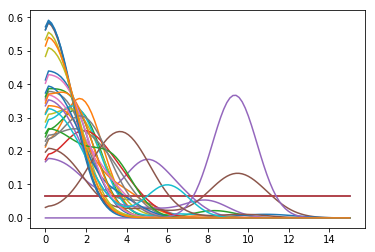

In [6]:
for protein, dists in indiv_stats.items():
    plt.plot(dists['native'].x, dists['native'].fx)

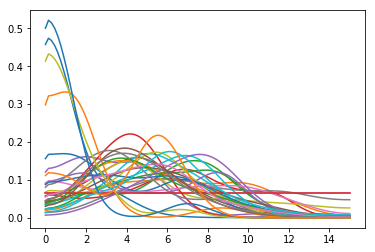

In [7]:
for protein, dists in indiv_stats.items():
    plt.plot(dists['reference'].x, dists['reference'].fx)

P03951


(-10, 10)

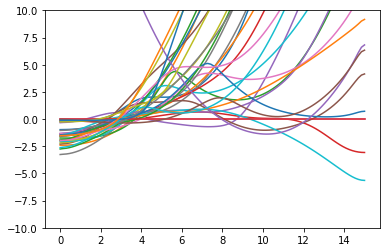

In [8]:
for protein, dists in indiv_stats.items():
    assert all(dists['reference'].x == dists['native'].x)
    plt.plot(dists['reference'].x, np.log(dists['reference'].fx) - np.log(dists['native'].fx))
    if (np.log(dists['reference'].fx) - np.log(dists['native'].fx))[0] > 1:
        print protein
plt.ylim(-10, 10)

# Merging

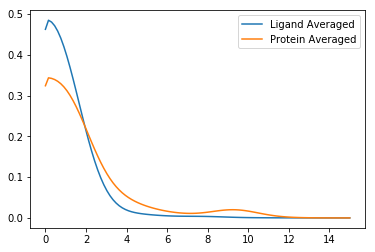

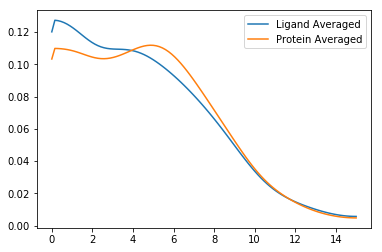

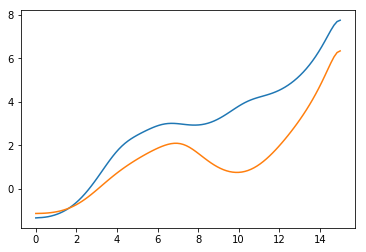

In [9]:
# Weighted by poses
def copy(self):
    de = DensityEstimate()
    de.points = self.points
    de.out_of_bounds = self.out_of_bounds
    de.sd = self.sd
    de.n_samples = self.n_samples
    de.reflect = self.reflect
    de.x = np.copy(self.x)
    de.fx = np.copy(self.fx)
    return de

def compare(dist):
    de1 = None
    for protein, dists in indiv_stats.items():
        if de1 is None:
            de1 = dists[dist]
        else:
            de1 = de1.average(dists[dist])
    plt.plot(de1.x, de1.fx, label = 'Ligand Averaged')

    # Weighted by protein
    de2 = None
    for protein, dists in indiv_stats.items():
        c = copy(dists[dist])
        c.n_samples = min(1, c.n_samples)
        if de2 is None:
            de2 = c
        else:
            de2 = de2.average(c)
    plt.plot(de2.x, de2.fx, label = 'Protein Averaged')
    plt.legend()
    plt.show()
    return de1, de2

native1, native2 = compare('native')
ref1,    ref2    = compare('reference')

plt.plot(native1.x, - np.log(native1.fx) + np.log(ref1.fx), label = 'Ligand Averaged')
plt.plot(native2.x, - np.log(native2.fx) + np.log(ref2.fx), label = 'Protein Averaged')
plt.show()

# MCSS stats used for all proteins

In [10]:
stats = {} # {Protein :  {dist : DensityEstimate}}
for fname in glob("{}/*/scores/pdb_crystal_only_mcss/*.txt".format(shared_paths['data'])):
    protein = fname.replace(shared_paths['data'], '').split('/')[0]
    dist = fname.split('/')[-1].split('_')[0]
    feature = fname.split('/')[-1].split('_')[1].split('.')[0]
    if protein not in stats: stats[protein] = {}
    stats[protein][dist] = DensityEstimate.read(fname)

P00489


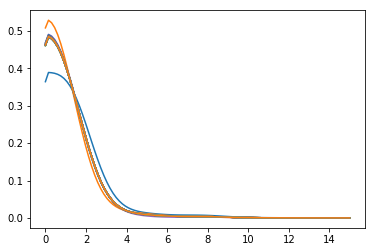

In [11]:
for protein, dists in stats.items():
    plt.plot(dists['native'].x, dists['native'].fx)
    if dists['native'].fx[0] < 0.45: print protein

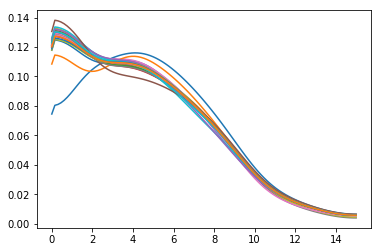

In [12]:
for protein, dists in stats.items():
    plt.plot(dists['reference'].x, dists['reference'].fx)

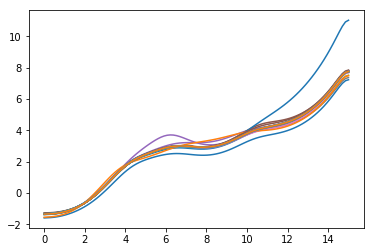

In [13]:
for protein, dists in stats.items():
    assert all(dists['reference'].x == dists['native'].x)
    plt.plot(dists['reference'].x, np.log(dists['reference'].fx) - np.log(dists['native'].fx))

# Breakdown of scoring with crystal poses

In [14]:
from pairs import LigPair
rmsd, gscore, mcss, mcss_score = [], [], [], []
max_ligands = 20
for protein in stats.keys():
    prot = Protein(protein)
    lm = prot.lm
    ligands = lm.docked(lm.pdb)[:max_ligands+1]
    self_docked = lm.st+'_lig'
    if self_docked in ligands:
        ligands.remove(self_docked)
    else:
        ligands.pop(-1)
    prot.load_docking(ligands)
    
    crystal_lig = '{}_crystal_lig'.format(lm.st)
    prot.load_docking([crystal_lig], load_fp = False, load_crystal = True, load_mcss = True)
    for ligand in ligands:
        lp = LigPair(prot.docking[lm.st].ligands[crystal_lig], prot.docking[lm.st].ligands[ligand],
                     ['mcss'], lm.mcss, 100)
        for (r1, r2), pp in sorted(lp.pose_pairs.items(), key = lambda x: x[0]):
            if pp.get_feature('mcss') is None: continue
            rmsd   += [pp.pose2.rmsd]
            mcss   += [pp.get_feature('mcss')]
            gscore += [pp.pose2.gscore]
            mcss_score += [np.log(stats[protein]['reference'](mcss[-1])) - np.log(stats[protein]['native'](mcss[-1]))]
rmsd, mcss, gscore, mcss_score = np.array(rmsd), np.array(mcss), np.array(gscore), np.array(mcss_score)

SpearmanrResult(correlation=0.82457086539509739, pvalue=0.0)
0.910063535949


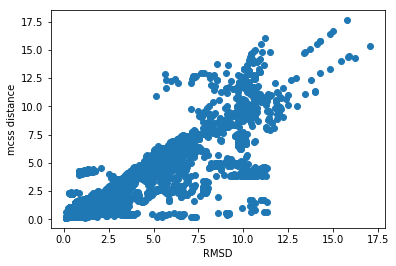

In [15]:
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score
def metrics(rmsd, metric):
    plt.scatter(rmsd, metric)
    print spearmanr(rmsd, metric)
    print roc_auc_score(rmsd > 2.0, metric)

metrics(rmsd, mcss)
plt.ylabel('mcss distance')
plt.xlabel('RMSD')
plt.show()

SpearmanrResult(correlation=0.82622345939657982, pvalue=0.0)
0.919321147216


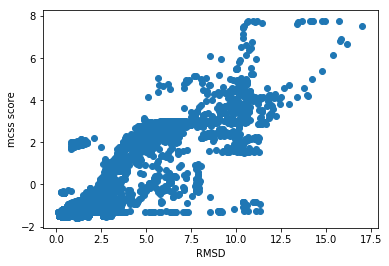

In [16]:
metrics(rmsd, mcss_score)
plt.ylabel('mcss score')
plt.xlabel('RMSD')
plt.show()

SpearmanrResult(correlation=0.65436790531300182, pvalue=0.0)
0.886469928553


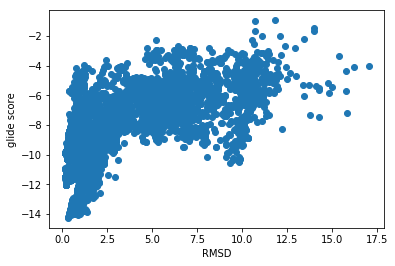

In [17]:
metrics(rmsd, gscore)
plt.ylabel('glide score')
plt.xlabel('RMSD')
plt.show()

SpearmanrResult(correlation=0.78315734473344323, pvalue=0.0)
0.944849165814


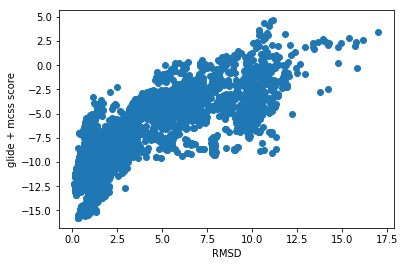

In [18]:
metrics(rmsd, gscore + mcss_score)
plt.ylabel('glide + mcss score')
plt.xlabel('RMSD')
plt.show()

SpearmanrResult(correlation=0.8366645104467052, pvalue=0.0)
0.940761597165


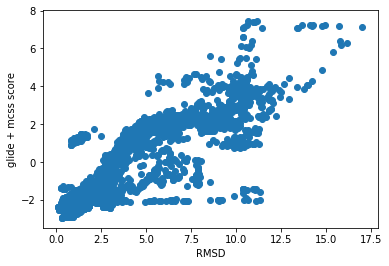

In [19]:
metrics(rmsd, 0.1*gscore + mcss_score)
plt.ylabel('glide + mcss score')
plt.xlabel('RMSD')
plt.show()

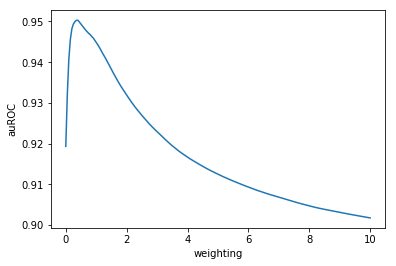

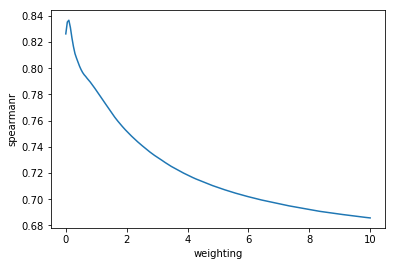

0.35175879397
0.100502512563


In [20]:
x = np.linspace(0, 10, 200)
y1 = []
y2 = []
for w in x:
    y1 += [roc_auc_score(rmsd > 2.0, w*gscore + mcss_score)]
    y2 += [spearmanr(rmsd, w*gscore + mcss_score)[0]]
plt.plot(x, y1)
plt.ylabel('auROC')
plt.xlabel('weighting')
plt.show()

plt.plot(x, y2)
plt.ylabel('spearmanr')
plt.xlabel('weighting')
plt.show()
print x[np.argmax(y1)]
print x[np.argmax(y2)]

# Broken by ligand

In [21]:
from pairs import LigPair
rmsd, gscore, mcss, mcss_score = [], [], [], []
ligs = []
max_ligands = 20
for protein in stats.keys():
    prot = Protein(protein)
    lm = prot.lm
    ligands = lm.docked(lm.pdb)[:max_ligands+1]
    self_docked = lm.st+'_lig'
    if self_docked in ligands:
        ligands.remove(self_docked)
    else:
        ligands.pop(-1)
    prot.load_docking(ligands)
    
    crystal_lig = '{}_crystal_lig'.format(lm.st)
    prot.load_docking([crystal_lig], load_fp = False, load_crystal = True, load_mcss = True)
    for ligand in ligands:
        rmsd += [[]]
        mcss += [[]]
        gscore += [[]]
        mcss_score += [[]]
        ligs += [(protein, ligand)]
        lp = LigPair(prot.docking[lm.st].ligands[crystal_lig], prot.docking[lm.st].ligands[ligand],
                     ['mcss'], lm.mcss, 100)
        for (r1, r2), pp in sorted(lp.pose_pairs.items(), key = lambda x: x[0]):
            if pp.get_feature('mcss') is None: continue
            rmsd[-1]   += [pp.pose2.rmsd]
            mcss[-1]   += [pp.get_feature('mcss')]
            gscore[-1] += [pp.pose2.gscore]
            mcss_score[-1] += [  np.log(stats[protein]['reference'](mcss[-1][-1]))
                               - np.log(stats[protein]['native'](mcss[-1][-1]))]

In [22]:
def average_metric(rmsds, preds, metric):
    metrics = []
    for rmsd, pred in zip(rmsds, preds):
        if not rmsd: continue
        try:
            metrics += [metric(rmsd, pred)]
        except ValueError:
            pass
    return np.mean(metrics)

def average(preds1, preds2, w):
    preds = []
    for pred1, pred2 in zip(preds1, preds2):
        preds += [w*np.array(pred1) + np.array(pred2)]
    return preds

def transform(rmsds):
    out = []
    for rmsd in rmsds:
        out += [[r > 2.0 for r in rmsd]]
    return out

def best_rmsd(rmsd, pred):
    return rmsd[np.argmin(pred)]

def best_correct(rmsd, pred):
    return best_rmsd(rmsd, pred) < 2.0

print average_metric(rmsd, gscore, spearmanr)
print average_metric(rmsd, mcss, spearmanr)
print average_metric(rmsd, mcss_score, spearmanr)
print average_metric(rmsd, average(gscore, mcss_score, 0), spearmanr)
print average_metric(rmsd, average(gscore, mcss_score, 1), spearmanr)
print average_metric(rmsd, average(gscore, mcss_score, 1.8), spearmanr)
print

print average_metric(transform(rmsd), gscore, roc_auc_score)
print average_metric(transform(rmsd), mcss, roc_auc_score)
print average_metric(transform(rmsd), mcss_score, roc_auc_score)
print average_metric(transform(rmsd), average(gscore, mcss_score, 0), roc_auc_score)
print average_metric(transform(rmsd), average(gscore, mcss_score, 1), roc_auc_score)
print average_metric(transform(rmsd), average(gscore, mcss_score, 1.8), roc_auc_score)
print 

print average_metric(rmsd, gscore, best_rmsd)
print average_metric(rmsd, mcss, best_rmsd)
print average_metric(rmsd, mcss_score, best_rmsd)
print average_metric(rmsd, average(gscore, mcss_score, 0), best_rmsd)
print average_metric(rmsd, average(gscore, mcss_score, 1), best_rmsd)
print average_metric(rmsd, average(gscore, mcss_score, 1.8), best_rmsd)
print 

print 1-average_metric(transform(rmsd), gscore, best_rmsd)
print 1-average_metric(transform(rmsd), mcss, best_rmsd)
print 1-average_metric(transform(rmsd), mcss_score, best_rmsd)
print 1-average_metric(transform(rmsd), average(gscore, mcss_score, 0), best_rmsd)
print 1-average_metric(transform(rmsd), average(gscore, mcss_score, 1), best_rmsd)
print 1-average_metric(transform(rmsd), average(gscore, mcss_score, 1.8), best_rmsd)
print 

0.23236105633
0.35372204105
0.344499361664
0.344499361664
0.28431494274
0.269853454746

0.812642941079
0.916205624793
0.916205624793
0.916205624793
0.946390564592
0.939703919065

2.44094290398
1.93634461992
1.93634461992
1.93634461992
1.82767206021
1.91222427019

0.7
0.771428571429
0.771428571429
0.771428571429
0.785714285714
0.785714285714



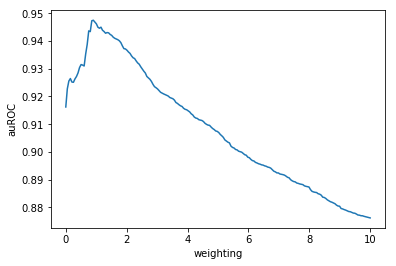

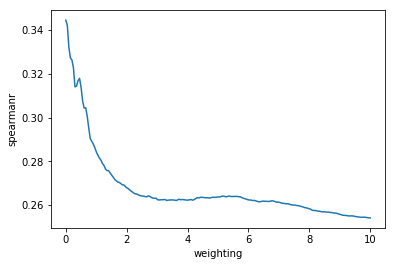

0.904522613065
0.0


In [23]:
x = np.linspace(0, 10, 200)
y1 = []
y2 = []
for w in x:
    y1 += [average_metric(transform(rmsd), average(gscore, mcss_score, w), roc_auc_score)]
    y2 += [average_metric(rmsd, average(gscore, mcss_score, w), spearmanr)]
plt.plot(x, y1)
plt.ylabel('auROC')
plt.xlabel('weighting')
plt.show()

plt.plot(x, y2)
plt.ylabel('spearmanr')
plt.xlabel('weighting')
plt.show()
print x[np.argmax(y1)]
print x[np.argmax(y2)]

# Find examples where we do worse for using MCSS

In [27]:
c = 0
for r, m, ms, g, l in zip(rmsd, mcss, mcss_score, gscore, ligs):
    if not r: continue
    m_i = np.argmin(np.array(g)*1.8 + np.array(m))
    g_r = r[np.argmin(g)]
    m_r = r[m_i]
    
    if g_r + 1 < m_r:
        print 'glide:  ', l, g[np.argmin(g)], m[np.argmin(g)], ms[np.argmin(g)], r[np.argmin(g)], 0
        print 'combind:', l, g[m_i], m[m_i], ms[m_i], r[m_i], m_i
c

0

In [28]:
c =0
for r, m, ms, g, l in zip(rmsd, mcss, mcss_score, gscore, ligs):
    if not r: continue
    m_i = np.argmin(np.array(g)*1.8 + np.array(m))
    m_r = r[m_i]
    
    if np.min(r) + 1 < m_r:
        print 'best:   ', l, g[np.argmin(r)], m[np.argmin(r)], ms[np.argmin(r)], np.min(r), np.argmin(r)
        print 'combind:', l, g[m_i], m[m_i], ms[m_i], r[m_i], m_i
c

best:    ('ERA', '2B1V_lig') -9.16 1.44823186619 -1.02062174868 0.626925107656 36
combind: ('ERA', '2B1V_lig') -9.57 1.28439896752 -1.09977409013 2.50691377966 0
best:    ('A2AR', '5N2R_lig') -8.06 5.7247461749 2.78959025996 4.84682148194 95
combind: ('A2AR', '5N2R_lig') -9.33 2.73634332495 0.111560500835 7.87227889556 0
best:    ('P03951', '4CRA_lig') -5.44 10.9089215077 4.16029590422 5.12248426445 48
combind: ('P03951', '4CRA_lig') -8.37 3.87435857284 1.59257214588 9.8899765453 0
best:    ('P03951', '4CRB_lig') -5.25 12.8356545824 5.06867861636 5.66403147179 62
combind: ('P03951', '4CRB_lig') -8.35 3.88323005547 1.60285157645 10.2095130441 0
best:    ('P03951', '4CRF_lig') -3.49 9.10745012411 3.20131555168 7.53172518866 87
combind: ('P03951', '4CRF_lig') -6.19 0.965370614873 -1.1687570731 9.90446686946 18


0

In [44]:
rmsd, gscore, mcss = [], [], []
ligand_size1, ligand_size2, mcss_size, ligs = [], [], [], []
max_ligands = 20
for protein in stats.keys():
    prot = Protein(protein)
    lm = prot.lm
    ligands = lm.docked(lm.pdb)[:max_ligands+1]
    self_docked = lm.st+'_lig'
    if self_docked in ligands:
        ligands.remove(self_docked)
    else:
        ligands.pop(-1)
    prot.load_docking(ligands)
    
    crystal_lig = '{}_crystal_lig'.format(lm.st)
    prot.load_docking([crystal_lig], load_fp = False, load_crystal = True, load_mcss = True)
    for ligand in ligands:
        m = lm.mcss.MCSSs['{}-{}'.format(crystal_lig, ligand)]
        if not m.rmsds: continue
        rmsd += [[]]
        mcss += [[]]
        gscore += [[]]
        
        ligs += [(protein, ligand)]
        ligand_size1 += [m.n_l1_atoms]
        ligand_size2 += [m.n_l2_atoms]
        mcss_size += [m.n_mcss_atoms]
        for r, pose in enumerate(prot.docking[lm.st].ligands[ligand].poses[:100]):
            rmsd[-1] += [pose.rmsd]
            gscore[-1] += [pose.gscore]
            mcss[-1] += [m.rmsds[(0, r)]]

70


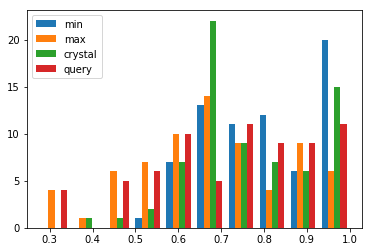

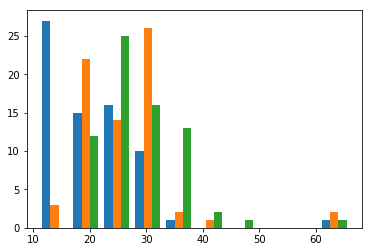

In [48]:
# Distributions
print len(mcss_size)

frac_min = [m / float(min(s1, s2)) for s1, s2, m in zip(ligand_size1, ligand_size2, mcss_size)]
frac_max = [m / float(max(s1, s2)) for s1, s2, m in zip(ligand_size1, ligand_size2, mcss_size)]
frac_cry = [m / float(s1) for s1, s2, m in zip(ligand_size1, ligand_size2, mcss_size)]
frac_que = [m / float(s2) for s1, s2, m in zip(ligand_size1, ligand_size2, mcss_size)]
plt.hist([frac_min, frac_max, frac_cry, frac_que], label = ['min', 'max', 'crystal', 'query'])
plt.legend()
plt.show()



plt.hist([mcss_size, ligand_size1, ligand_size2], label = ['mcss', 'crystal', 'query'])
plt.show()

SpearmanrResult(correlation=0.56434728277355717, pvalue=3.6160384764139266e-07)
SpearmanrResult(correlation=0.63380530670504831, pvalue=3.8756671850706465e-09)
SpearmanrResult(correlation=0.43394287685274785, pvalue=0.00017474245759260159)
SpearmanrResult(correlation=0.67580741085210216, pvalue=1.374332545319677e-10)

SpearmanrResult(correlation=0.55462989135386909, pvalue=6.2937038296396689e-07)
SpearmanrResult(correlation=0.29317684708364206, pvalue=0.013773655861334777)
SpearmanrResult(correlation=0.01959120227147701, pvalue=0.87211244046775693)


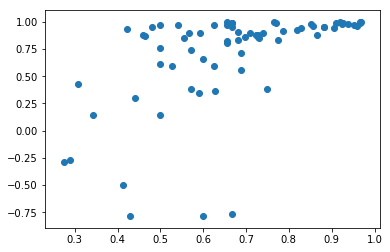

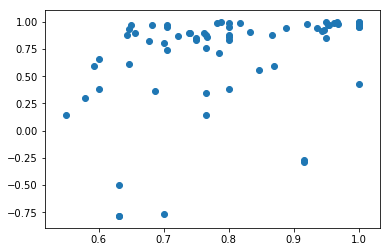

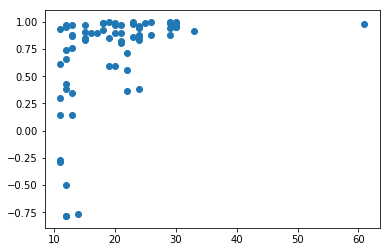

In [66]:
# Correlations
corr = [spearmanr(r, m)[0] for m, r in zip(rmsd, mcss)]

print spearmanr(corr, frac_min)
print spearmanr(corr, frac_max)
print spearmanr(corr, frac_cry)
print spearmanr(corr, frac_que)
print
print spearmanr(corr, mcss_size)
print spearmanr(corr, ligand_size1)
print spearmanr(corr, ligand_size2)

plt.scatter(frac_max, corr)
plt.show()

plt.scatter(frac_min, corr)
plt.show()

plt.scatter(mcss_size, corr)
plt.show()

In [68]:
corr = [spearmanr(r, m)[0] for m, r in zip(rmsd, mcss)]
for l, c, f in zip(ligs, corr, frac_max):
    if c < 0 and f > 0.5:
        print l, c, f

('ERA', '2B1V_lig') -0.787209783789 0.6
('ERA', '2B1Z_lig') -0.766070571291 0.666666666667
